In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.18.5


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Setup

In [6]:
VERSION = 11
# подключил к ноутбуку свой внешний датасет
DIR_TRAIN = 'C:\\Users\\Екатерина\\Project5_Autho(Unit6)\\input\\sf-autoru-solve-v4\\'
DIR_TEST = 'C:\\Users\\Екатерина\\Project5_Autho(Unit6)\\input\\sf-dst-car-price\\'
VAL_SIZE = 0.33   # 33%
N_FOLDS = 5

# CATBOOST
ITERATIONS = 2000
LR = 0.1

# Подготовка датасета train для обучения модели

После предварительного анализа данных в датафрейме test, были определены лишние "избыточные" признаки и исключены из сбора данных.

In [2401]:
import requests  
import pandas as pd
import math

#Анализ трафика с auto.ru показал, что ответные данные ограничены 99 страницами по 37 карточек на каждой,
#поэтому пришлось разбить все запросы по маркам авто и моделям, соответствующим тестовой выборке
mark_list = ['ACURA','ALFA_ROMEO','AUDI','BENTLEY','BMW','CADILLAC','CHERY','CHEVROLET','CHRYSLER','CITROEN','DAEWOO','DAIHATSU','DATSUN','DODGE','FIAT','FORD','GEELY','GREAT_WALL','HAVAL','HONDA','HYUNDAI','INFINITI','ISUZU','JAGUAR','JEEP','KIA','VAZ','LAND_ROVER','LEXUS','LIFAN','MAZDA','MERCEDES','MINI','MITSUBISHI','NISSAN','OPEL','PEUGEOT','PORSCHE','RAVON','RENAULT','ROVER','SAAB','SEAT','SKODA','SSANG_YONG','SUBARU','SUZUKI','TOYOTA','VOLKSWAGEN','VOLVO','VORTEX','GAZ','ZAZ','IG','LUAZ','UAZ']
mark_short_list = ['BMW','VOLKSWAGEN','NISSAN','MERCEDES','TOYOTA','AUDI','MITSUBISHI','SKODA','VOLVO','HONDA','INFINITI','LEXUS']
model_dict = {'BMW': ['5ER','3ER','X5','7ER','X6','X3','1ER','X1','6ER','X4','X6_M','4','X5_M','X7','M5','8ER','Z4','I3','M3','X2','2ER','M6','2ACTIVETOURER','Z3','321','2GRANDTOURER','M4','X3_M','M2','X4_M','340','I8','02','M1','Z1','Z3M','326','E3'],
 'VOLKSWAGEN': ['PASSAT','POLO','TIGUAN','TOUAREG','GOLF','JETTA','TRANSPORTER','MULTIVAN','PASSAT_CC','CARAVELLE','CADDY','TOURAN','GOLF_PLUS','AMAROK','SHARAN','BORA','GOLF_GTI','SCIROCCO','BEETLE','PHAETON','TERAMONT','VENTO','POINTER','GOLF_R','TYPE_1','EOS','CORRADO','LUPO','EUROVAN','CALIFORNIA','ARTEON','TARO','GOLF_R32','ATLAS','FOX','POLO_GTI'],
 'NISSAN': ['X_TRAIL','QASHQAI','ALMERA','TEANA','JUKE','MURANO','PRIMERA','ALMERA_CLASSIC','PATHFINDER','TIIDA','NOTE','TERRANO','PATROL','MAXIMA','MICRA','QASHQAI_PLUS_2','SENTRA','LEAF','SERENA','NAVARA','SKYLINE','CEFIRO','SUNNY','CUBE','NP300','LAUREL','MARCH','BLUEBIRD','ALTIMA','GT_R','BLUEBIRD_SYLPHY','PRESAGE','VANETTE','ALMERA_TINO','LIBERTY','WINGROAD','AD','CEDRIC','350Z','NV200','DATSUN','DAYZ','AVENIR','PULSAR','ARMADA','ELGRAND','EXPERT','BASSARA','CARAVAN_COACH','GLORIA','LARGO','SAFARI','JUKE_NISMO','TINO','PRAIRIE','STAGEA','CLIPPER','QUEST','FUGA','DAYZ_ROOX','SILVIA','PRESIDENT','300ZX','KIX','100NX','200SX','PRESEA','280ZX','RNESSA','OTTI','TERRANO_REGULUS','LAFESTA','URVAN','FAIRLADY_Z'],
 'MERCEDES': ['E_KLASSE','S_KLASSE','C_KLASSE','M_KLASSE','GL_KLASSE','G_KLASSE','GLK_KLASSE','CLS_KLASSE','GLE_KLASSE','GLC_KLASSE','A_KLASSE','CLA_KLASSE','GLS_KLASSE','V_KLASSE','VIANO','G_KLASSE_AMG','GLA_CLASS','S_KLASSE_AMG','B_KLASSE','VITO','S_CLASS_MAYBACH','GLE_KLASSE_COUPE','CL_KLASSE','W124','CLK_KLASSE','E_KLASSE_AMG','GLC_COUPE','SL_KLASSE','SLK_KLASSE','R_KLASSE','M_KLASSE_AMG','GLE_KLASSE_COUPE_AMG','W201','C_KLASSE_AMG','W123','GLE_KLASSE_AMG','CLS_KLASSE_AMG','AMG_GT','SL_KLASSE_AMG','A_KLASSE_AMG','CLC_KLASSE','GLA_CLASS_AMG','GL_KLASSE_AMG','GLS_KLASSE_AMG','CL_KLASSE_AMG','GLC_KLASSE_AMG','CLA_KLASSE_AMG','SLS_AMG','W111','W128','190_SL','AMG_GLC_COUPE','CITAN','MAYBACH_GLS','X_KLASSE','W188','SLC_KLASSE','VANEO','W186','SIMPLEX','SLR_KLASSE','W114','W136','GLB_KLASSE'],
 'TOYOTA': ['CAMRY','LAND_CRUISER','COROLLA','RAV_4','LAND_CRUISER_PRADO','AVENSIS','HIGHLANDER','AURIS','MARK_II','CELICA','HILUX','YARIS','PRIUS','HIACE','CROWN','VERSO','TUNDRA','ALPHARD','CHASER','CARINA','CALDINA','4RUNNER','VENZA','CARINA_E','SIENNA','VITZ','FORTUNER','CRESTA','ESTIMA','LITE_ACE','SEQUOIA','TOWN_ACE','CORONA','MATRIX','SPRINTER','HARRIER','VISTA','COROLLA_LEVIN','VOXY','HILUX_SURF','ALTEZZA','C_HR','PREVIA','SUPRA','ARISTO','COROLLA_SPACIO','SOARER','AQUA','BB','GT86','FJ_CRUISER','PRIUS_ALPHA','CAMRY_SOLARA','MARK_X','IPSUM','PASSO','CAMI','BLADE','CORSA','FUNCARGO','PROBOX','WINDOM','SPRINTER_MARINO','VEROSSA','AVALON','NOAH','COROLLA_VERSO','IQ','ISIS','STARLET','COROLLA_RUMION','SUCCEED','REGIUS','MR2','DUET','CYNOS','TERCEL','VANGUARD','SPRINTER_CARIB','WISH','CROWN_MAJESTA','ALLEX','PICNIC','AVENSIS_VERSO','RAUM','CORONA_EXIV','PREMIO','ECHO','CARINA_ED','ESQUIRE','WILL','PRIUSPLUS','SPRINTER_TRUENO','GRAND_HIACE','OPA','SERA','CURREN','GRANVIA','MR_S','IST','SPARKY','MASTER_ACE_SURF','CAVALIER','COROLLA_II','PASEO','ORIGIN','GAIA','WILL_CYPHA','SPADE','VERSO_S','VELLFIRE','PLATZ','SCEPTER_SEDAN','SIENTA','MEGA_CRUISER','PORTE','RACTIS','AYGO','MARK_X_ZIO','NADIA','YARIS_VERSO','PROGRES'],
 'AUDI': ['A6','A4','Q7','Q5','A3','A5','A8','80','Q3','100','ALLROAD','A7','TT','A1','A4_ALLROAD','Q8','S8','RS6','S5','90','S4','S6','S3','R8','RS5','COUPE','RSQ3','RS7','200','TTS','A2','RS3','S7','SQ5','RS4','V8','920','TT_RS','E_TRON'],
 'MITSUBISHI': ['LANCER','OUTLANDER','PAJERO','PAJERO_SPORT','GALANT','ASX','CARISMA','L200','COLT','MONTERO_SPORT','GRANDIS','ECLIPSE','MONTERO','SPACE_STAR','SPACE_WAGON','PAJERO_PININ','LANCER_EVOLUTION','DELICA','PAJERO_IO','CHARIOT','LEGNUM','ECLIPSE_CROSS','PAJERO_MINI','AIRTREK','DIAMANTE','DION','MIRAGE','SPACE_RUNNER','RVR','DINGO','ENDEAVOR','SPACE_GEAR','LIBERO','L400','DELICA_D2','DELICA_D_5','ASPIRE','EK_WAGON','L300','I_MIEV','LANCER_RALLIART','EMERAUDE','MINICA','MINICAB','FTO','SIGMA'],
 'SKODA': ['OCTAVIA','RAPID','SUPERB','FABIA','YETI','KODIAQ','FELICIA','OCTAVIA_RS','ROOMSTER','FABIA_RS','KAROQ','120','FAVORIT','POPULAR','100_SERIES'],
 'VOLVO': ['XC90','S60','XC60','S80','S40','XC70','C30','850','940','V40_CC','V40','V70','960','S90','740','S70','C70','460','V50','XC40','V90_CROSS_COUNTRY','240_SERIES','760','440','V60','S60_CROSS_COUNTRY','V60_CROSS_COUNTRY','140'],
 'HONDA': ['CIVIC','ACCORD','CR_V','PILOT','HR_V','JAZZ','FIT','PRELUDE','STEPWAGON','STREAM','LEGEND','CROSSTOUR','SHUTTLE','FREED','CIVIC_TYPE_R','INTEGRA','ELEMENT','ODYSSEY','CIVIC_FERIO','N_BOX','RIDGELINE','N_WGN','S2000','MOBILIO','CONCERTO','ORTHIA','ODYSSEY_NA','AVANCIER','INSIGHT','SABER','FR_V','CR_Z','ELYSION','PARTNER','AIRWAVE','Z','CROSSROAD','VEZEL','ZEST','CR_X','ASCOT','MOBILIO_SPIKE','INSPIRE','RAFAGA','DOMANI','ACTY','LOGO','TORNEO','CITY','VIGOR'],
 'INFINITI': ['FX','G35','QX56','QX70','M','EX','Q50','QX50','QX80','JX','QX60','Q70','QX4','Q','Q60','I','Q30','QX30'],
 'LEXUS': ['RX','LX','GS','NX','ES','LS','IS','GX','CT','UX','SC','RC','LM','HS']}

PAGE_SIZE = 37

color_codes = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}

headers={   'Accept': '*/*',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3',
            'Connection': 'keep-alive',
            'Content-Length': '137',
            'content-type': 'application/json',
            'Cookie': 'suid=cd83b44d7f75dafa56fe3778e499e7e3.14567f5b8f06ffcc4a784b00a9290df9; yandexuid=7504461381597737950; my=YwA%3D; tmr_lvid=f7af115a3b9f96f3786f7bafc5d3db7c; tmr_lvidTS=1610351490193; _ga=GA1.2.821239054.1610351491; autoruuid=g5ffacd0c26fi3nia8mhf8le0ldr7o4q.0660197805faad6b7725e6eeef1f3d7e; hide-proauto-pimple=1; _fbp=fb.1.1613374042201.1232031672; mmm-search-accordion-is-open-cars=%5B0%5D; _csrf_token=aeb301f2db4ba81e61b09e8925938c9aa77211b57936308c; from=direct; autoru_sid=1923229%7C1618921829656.7776000.MI6ulN2uaipivugoi7jOwg.7bbdg81PpkXdWV8Ro7DwOMJE7Vt3cOCmL1pcEil9vVg; gdpr=0; bltsr=1; card_prevnext_swipe_info=1; mindboxDeviceUUID=d53dccf1-c591-444e-8738-88b36eb21f1b; directCrm-session=%7B%22deviceGuid%22%3A%22d53dccf1-c591-444e-8738-88b36eb21f1b%22%7D; tmr_reqNum=19; lv=1619018081; spravka=dD0xNjE5NDIxNTM1O2k9MTA5LjI1Mi44MS4xMTt1PTE2MTk0MjE1MzU0Mzc1Mjc5MDc7aD0xNWY5MjdhZDQ2ODAyODY5NGRhNjhhMDkxMGExZDgxOA==; listing_view_session={%22sort%22:%22cr_date-desc%22}; listing_view=%7B%22version%22%3A1%7D; gradius=100; gids=; _ym_isad=1; autoru-visits-count=25; yuidlt=1; crookie=3tYpjLP+6oP3w+dSbrUe6IfEPrgiynFoFM4Xnzs5MbAe8OIibKhN/lA7iUEAssCv9ys+W91NeXgOMK8gTDChFvxFLOg=; cmtchd=MTYxOTYzMjU2NDU4MA==; X-Vertis-DC=vla; _ym_uid=1614604810355124960; from_lifetime=1619633901101; _ym_d=1619633903',
            'Host': 'auto.ru',
            'origin': 'https://auto.ru',
            'Referer': 'https://auto.ru/cars/used/',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36',
            'x-client-app-version': 'e47089ba95',
            'x-client-date': '1619633909706',
            'x-csrf-token': 'aeb301f2db4ba81e61b09e8925938c9aa77211b57936308c',
            'x-page-request-id': '691a928f428c2fef8edd8da7ba29e54e',
            'x-requested-with': 'fetch'
        }
#По этим двум URL получаем JSON с общим количеством авто по марке и модели, а также карточки со всеми необходимыми данными по каждому авто
counter_url = 'https://auto.ru/-/ajax/desktop/listingCount/'
list_url = 'https://auto.ru/-/ajax/desktop/listing/'

#общая функция получения данных по двум типам запросов
def get_page(page_type, params):
    if page_type == 'counter':
        url = counter_url
    else:
        url = list_url
    try:
        response = requests.post(url, headers=headers, json=params)
        response.encoding ='utf8'
        data = response.json()
        # print(data)
        if data['status'] == 'SUCCESS':
            if page_type == 'counter':
                return data['pagination']['total_offers_count']
            else:
                return data['offers']
        else:
            print(f'Params: {params}, Bad response: {data}')
            return -1
    except:
        print('Error getting url: ', params)
        return -1

#Для ускорения будем сразу отсеивать дубликаты
sell_id_list = []

#Будем выгружать только полезные данные, которые будут использоваться в построении модели
pd.DataFrame(columns=['bodyType','brand','car_url','color','complectation_dict','engineDisplacement','enginePower','equipment_dict','fuelType','mileage','modelDate','model_info','model_name','numberOfDoors','priceCurrency','productionDate','sell_id','vehicleTransmission','vendor','Владельцы','ПТС','Привод','Руль','seller_type','price']).to_csv('D:/Downloads/Python/cars.csv', mode='w', header=True, index=False)

#циклы по маркам и моделям
for mark in mark_short_list:
    for model in model_dict[mark]:
        #Получаем общее число предложений по марке и модели
        #Выбираем б/у авто, сортируем выборку по дате размещения
        params = {"catalog_filter":[{"mark":mark,"model":model}],"section":"used","category":"cars","sort":"cr_date-desc"}
        offers = get_page('counter', params)
        if offers in [-1, 0]:
            continue

        print(f'Mark: {mark}, model: {model}, offers:{offers}')

        #Будем собирать данные в датафрейм
        df = pd.DataFrame()
        
        #Цикл по всем страницам
        for page in range(1, math.ceil(offers/PAGE_SIZE + 1)):
            #Получаем страницу, содержащую 37 карточек авто со всеми данными
            params = {'category':'cars','section':'used','sort':'cr_date-desc','catalog_filter':[{"mark":mark,"model":model}],'page':page}
            data = get_page('list', params)
            if data in [-1, 0]:
                continue
                        
            for car in data:
                #Для каждой карточки авто заполняем словарь
                car_dict = {}

                #Неактивные карточки пропускаем                
                if car['status'] == 'INACTIVE':
                    continue
                sell_id = str(car['id'])
                #Пропускаем дубликаты уже выгруженных карточек
                if (sell_id in sell_id_list):
                    continue
                sell_id_list += sell_id
                car_dict['sell_id'] = sell_id
                car_dict['price'] = str(car['price_info']['price'])

                #Парсим данные по каждому авто. Подгоняем некоторые данные под тестовую выборку
                try:
                    car_dict['bodyType'] = car['vehicle_info']['configuration']['human_name'].lower()
                except:
                    continue
                car_dict['brand'] = car['vehicle_info']['mark_info']['code']
                
                try:
                    car_dict['color'] = color_codes[car['color_hex']]
                except:
                    print('color: ', car['color_hex'])
                    car_dict['color'] = ''
                    
                if ('complectation' in car['vehicle_info']) and (car['vehicle_info']['complectation']['id'] != '0'):
                    car_dict['complectation_dict'] = car['vehicle_info']['complectation']
                else:
                    car_dict['complectation_dict'] = ''
                car_dict['enginePower'] = str(car['vehicle_info']['tech_param']['power']) + ' N12'
                car_dict['equipment_dict'] = car['vehicle_info']['equipment']
                
                fuel = car['vehicle_info']['tech_param']['engine_type']
                if fuel == 'GASOLINE':
                    car_dict['fuelType'] = 'бензин'
                    car_dict['engineDisplacement'] = car['lk_summary'][:3] + ' LTR'
                elif fuel == 'DIESEL':
                    car_dict['fuelType'] = 'дизель'
                    car_dict['engineDisplacement'] = car['lk_summary'][:3] + ' LTR'
                elif fuel == 'ELECTRO':
                    car_dict['fuelType'] = 'электро'
                    car_dict['engineDisplacement'] = ''
                elif fuel == 'HYBRID':
                    car_dict['fuelType'] = 'гибрид'
                    car_dict['engineDisplacement'] = car['lk_summary'][:3] + ' LTR'
                elif fuel == 'LPG':
                    car_dict['fuelType'] = 'газ'
                    car_dict['engineDisplacement'] = car['lk_summary'][:3] + ' LTR'
                else:
                    car_dict['fuelType'] = fuel
                    car_dict['engineDisplacement'] = car['lk_summary'][:3] + ' LTR'
                    
                car_dict['mileage'] = str(car['state']['mileage'])
                car_dict['modelDate'] = str(car['vehicle_info']['super_gen']['year_from'])
                car_dict['model_info'] = car['vehicle_info']['model_info']
                model_name = car['vehicle_info']['model_info']['code']
                car_dict['model_name'] = model_name
                sale_id = car['saleId']
                car_dict['car_url'] = 'https://auto.ru/cars/used/sale/' + mark + '/' + model_name + '/' + sale_id + '/'

                car_dict['numberOfDoors'] = str(car['vehicle_info']['configuration']['doors_count'])
                car_dict['priceCurrency'] = car['price_info']['currency']
                car_dict['productionDate'] = str(car['documents']['year'])
                
                transmission = car['vehicle_info']['tech_param']['transmission']
                if transmission == 'MECHANICAL':
                    car_dict['vehicleTransmission'] = 'механическая'
                elif transmission == 'AUTOMATIC':
                    car_dict['vehicleTransmission'] = 'автоматическая'
                elif transmission == 'ROBOT':
                    car_dict['vehicleTransmission'] = 'роботизированная'
                elif transmission == 'VARIATOR':
                    car_dict['vehicleTransmission'] = 'вариатор'
                else:
                    car_dict['vehicleTransmission'] = transmission
                    
                car_dict['vendor'] = car['vehicle_info']['vendor']
                
                try:
                    owners = car['documents']['owners_number']
                except:
                    owners = 0
                if owners == 1:
                    car_dict['Владельцы'] = '1 владелец'
                elif owners == 2:
                    car_dict['Владельцы'] = '2 владельца'
                elif owners >= 3:
                    car_dict['Владельцы'] = '3 или более'
                else:
                    car_dict['Владельцы'] = ''
                
                try:
                    pts = car['documents']['pts']
                except:
                    pts = ''
                if pts == 'ORIGINAL':
                    car_dict['ПТС'] = 'Оригинал'
                elif pts == 'DUPLICATE':
                    car_dict['ПТС'] = 'Дубликат'
                else:
                    car_dict['ПТС'] = ''
                    
                gear = car['vehicle_info']['tech_param']['gear_type']
                if gear == 'REAR_DRIVE':
                    car_dict['Привод'] = 'задний'
                elif gear == 'FORWARD_CONTROL':
                    car_dict['Привод'] = 'передний'
                elif gear == 'ALL_WHEEL_DRIVE':
                    car_dict['Привод'] = 'полный'
                else:
                    print('gear: ', gear)
                    
                wheel = car['vehicle_info']['steering_wheel']
                if wheel == 'LEFT':
                    car_dict['Руль'] = 'Левый'
                else:
                    car_dict['Руль'] = 'Правый'
                    
                car_dict['seller_type'] = car['seller_type']

                df = df.append(car_dict, ignore_index=True)
                
        #Добавляем данные по марке и региону в файл
        if not df.empty:
            df.to_csv('D:/Downloads/Python/cars.csv', mode='a', header=False, index=False,
                 columns=['bodyType','brand','car_url','color','complectation_dict','engineDisplacement','enginePower','equipment_dict','fuelType','mileage','modelDate','model_info','model_name','numberOfDoors','priceCurrency','productionDate','sell_id','vehicleTransmission','vendor','Владельцы','ПТС','Привод','Руль','seller_type','price'])

# Data

In [7]:
train = pd.read_csv(DIR_TRAIN+'train.csv')  # мой датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

## Data Preprocessing

Для формироавния процедуры обработки данных проведем их анализ.

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

В датасете test представлено 26 каттегориальных и 6 числовых переменных. Пропуски содержат 4 переменные: complectation_dict, equipment_dict, Владение, ПТС.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191120 entries, 0 to 191119
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             191120 non-null  object
 1   brand                191120 non-null  object
 2   car_url              191120 non-null  object
 3   color                191120 non-null  object
 4   complectation_dict   29962 non-null   object
 5   engineDisplacement   190832 non-null  object
 6   enginePower          191120 non-null  object
 7   equipment_dict       191120 non-null  object
 8   fuelType             191120 non-null  object
 9   mileage              191120 non-null  int64 
 10  modelDate            191120 non-null  int64 
 11  model_info           191120 non-null  object
 12  model_name           191120 non-null  object
 13  numberOfDoors        191120 non-null  int64 
 14  priceCurrency        191120 non-null  object
 15  productionDate       191120 non-nu

В тренировочном датасете пропуски значений есть в признаках engineDisplacement, complectation_dict, Владельцы, ПТС.
Добавлены новый столбец: тип продавца (seller_type), для тестовой выборки данная информация будет получена из description.
Добавлена целевая переменная price.

Также при сборе исключались избыточные и некоторые технические признаки:  

      description - мало уникальной информации, в основном она уже содержится в других столбцах

      vehicleConfiguration - информация дублируется в столбцах bodyType, vehicleTransmission, engineDisplacement

      image - не представляет пользы для моедли, пропущенных значений нет, изображение есть у всех объявлений
      
      name - дублирует столбцы engineDisplacement, enginePower, Привод, не может быть использован для устранения пропусков в данных столбцах

      Состояние - одно значение - Не требует ремонта

      Таможня - одно значение - Растаможен
      
      parsing_unixtime- техническая переменная
      
      super_gen  - отсутсвует потенциально полезная информация
      
      Владение - много пропущенных данных 
      

Прочие технические столбцы и столбцы с дублированной информацией пока оставим для дальнешего анализа.

Выровняем данные в выборках по типам и названиям признаков, удалим "избыточные" признаки из test

In [10]:
# сравнение состава столбцов в test и train:
print(list(set(test.columns) - set(train.columns)))
print(list(set(train.columns) - set(test.columns)))

['vehicleConfiguration', 'super_gen', 'Таможня', 'parsing_unixtime', 'description', 'image', 'Владение', 'Состояние', 'name']
['seller_type', 'price']


In [11]:
test.drop(['Владение', 'name', 'vehicleConfiguration', 'image',
           'Состояние', 'Таможня', 'parsing_unixtime', 'super_gen'], axis=1, inplace=True)
# изменим название discription на целевое - seller_type до обработки
test.rename(columns={'description': 'seller_type'}, inplace=True)

In [12]:
# сравнение типов столбцов:
for c in test.columns:
    if c in train.columns:
        if test[c].dtypes != train[c].dtypes:
            print(c)
    else:
        print(c, 'does not exist in train!')

In [13]:
# переведем значения по которым есть расхождения для train в object:
# for i in ['engineDisplacement','enginePower']:
#    train[i] = train[i].astype('object')

In [14]:
# предобработка для кавычек для json - столбцов
train.model_info = train.model_info.apply(lambda x: x.replace('\'', '\"'))
train.equipment_dict = train.equipment_dict.apply(
    lambda x: x.replace('\'', '\"'))

In [15]:
# для корректной обработки и анализа признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения price, мы его должны предсказать, по этому пока просто заполняем нулями
test['price'] = 0

data = test.append(train, sort=False).reset_index(
    drop=True)  # объединяем

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225806 entries, 0 to 225805
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             225806 non-null  object
 1   brand                225806 non-null  object
 2   car_url              225806 non-null  object
 3   color                225806 non-null  object
 4   complectation_dict   36380 non-null   object
 5   seller_type          225806 non-null  object
 6   engineDisplacement   225518 non-null  object
 7   enginePower          225806 non-null  object
 8   equipment_dict       215810 non-null  object
 9   fuelType             225806 non-null  object
 10  mileage              225806 non-null  int64 
 11  modelDate            225806 non-null  int64 
 12  model_info           225806 non-null  object
 13  model_name           225806 non-null  object
 14  numberOfDoors        225806 non-null  int64 
 15  priceCurrency        225806 non-nu

Итого, есть пропуски в значениях: complectation_dict, engineDisplacement,equipment_dict, Владельцы, ПТС

In [17]:
# посмотрим, есть ли дубли:
data.sell_id.count() - data.sell_id.nunique()  # 1823 пересекающихся значений

1823

In [18]:
# удалим из train дубликаты
duplist = data['sell_id'].value_counts(
)[data['sell_id'].value_counts() > 1].index

In [19]:
train = train.drop(train[train['sell_id'].isin(duplist)].index)

In [20]:
# удалим дубликаты из data
data.drop_duplicates(subset=['sell_id'], inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223983 entries, 0 to 225805
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bodyType             223983 non-null  object
 1   brand                223983 non-null  object
 2   car_url              223983 non-null  object
 3   color                223983 non-null  object
 4   complectation_dict   36100 non-null   object
 5   seller_type          223983 non-null  object
 6   engineDisplacement   223707 non-null  object
 7   enginePower          223983 non-null  object
 8   equipment_dict       213987 non-null  object
 9   fuelType             223983 non-null  object
 10  mileage              223983 non-null  int64 
 11  modelDate            223983 non-null  int64 
 12  model_info           223983 non-null  object
 13  model_name           223983 non-null  object
 14  numberOfDoors        223983 non-null  int64 
 15  priceCurrency        223983 non-nu

1. bodyType

In [22]:
data.bodyType.value_counts()

седан                               86059
внедорожник 5 дв.                   64270
хэтчбек 5 дв.                       28144
универсал 5 дв.                     10083
лифтбек                              7886
                                    ...  
пикап полуторная кабина king cab        1
универсал 5 дв. crossover 7             1
купе fd                                 1
хэтчбек 5 дв. executive                 1
седан ewb                               1
Name: bodyType, Length: 219, dtype: int64

In [23]:
# составим словарь по типам автомобильных кузовов:
bodyTypedict = ['седан', 'компактвэн', 'универсал', 'купе-хардтоп', 'микровэн', 'седан-хардтоп', 'хэтчбек', 'купе', 'лимузин', 'микроавтобус', 'минивэн', 'чардтоп', 'таун-кар',
                'внедорожник', 'комби', 'лифтбек', 'фастбек', 'кабриолет', 'родстер', 'фаэтон', 'ландо', 'брогам', 'тарга', 'спайдер', 'шутингбрейк', 'пикап', 'фастбек', 'фургон']

In [24]:
# преобразовываем данные по словарю:
data.bodyType = data.bodyType.apply(lambda x: re.split(
    ' ', x.lower())[0] if re.split(' ', x.lower())[0] in bodyTypedict else x)

In [25]:
data.bodyType.value_counts()

седан            87729
внедорожник      68475
хэтчбек          33637
универсал        11143
лифтбек           8220
компактвэн        4395
минивэн           4126
купе              2698
пикап             1345
фургон             946
купе-хардтоп       418
кабриолет          243
родстер            220
седан-хардтоп      159
микровэн           140
фастбек             74
лимузин              6
тарга                6
фаэтон               3
Name: bodyType, dtype: int64

2. brand

In [26]:
# не замечено аномалий в значениях, оставим столбец без обработки
brandlist = data.brand.value_counts()[data.brand.value_counts() >= 1]

In [27]:
brandlist.index.to_list()

['VAZ',
 'TOYOTA',
 'VOLKSWAGEN',
 'NISSAN',
 'BMW',
 'MERCEDES',
 'HYUNDAI',
 'KIA',
 'AUDI',
 'MITSUBISHI',
 'SKODA',
 'FORD',
 'CHEVROLET',
 'RENAULT',
 'OPEL',
 'MAZDA',
 'HONDA',
 'VOLVO',
 'LEXUS',
 'DAEWOO',
 'PEUGEOT',
 'UAZ',
 'LAND_ROVER',
 'GAZ',
 'INFINITI',
 'SUBARU',
 'SUZUKI',
 'CITROEN',
 'CHERY',
 'PORSCHE',
 'LIFAN',
 'SSANG_YONG',
 'ZAZ',
 'GEELY',
 'DATSUN',
 'JEEP',
 'DODGE',
 'JAGUAR',
 'GREAT_WALL',
 'FIAT',
 'CADILLAC',
 'CHRYSLER',
 'MINI',
 'IG',
 'VORTEX',
 'SAAB',
 'RAVON',
 'HAVAL',
 'DAIHATSU',
 'BENTLEY',
 'SEAT',
 'LUAZ',
 'ROVER',
 'ALFA_ROMEO',
 'ACURA',
 'ISUZU']

3. color

In [28]:
# не замечено аномалий в значениях, оставим столбец без обработки
data.color.value_counts()

чёрный         52159
белый          44998
серебристый    30173
серый          29038
синий          20250
красный        12480
зелёный         9563
коричневый      8920
бежевый         4901
голубой         3518
золотистый      1921
пурпурный       1745
фиолетовый      1637
жёлтый          1318
оранжевый       1261
розовый          101
Name: color, dtype: int64

4. engineDisplacement

In [29]:
data.engineDisplacement.value_counts().head(10)

1.6 LTR    59349
2.0 LTR    39237
1.5 LTR    16751
1.8 LTR    15597
3.0 LTR    13611
1.4 LTR    13322
2.5 LTR    10280
2.4 LTR     9421
3.5 LTR     5004
1.7 LTR     4667
Name: engineDisplacement, dtype: int64

In [30]:
# избавимся от ед. измерения в данных (LTR):
data.engineDisplacement = data.engineDisplacement.apply(lambda x: None if pd.isna(x) else re.findall(
    '^\d\.\d', x)[-1] if len(re.findall('\d\.\d', x)) >= 1 else None)

In [31]:
data[pd.isna(data['engineDisplacement'])].fuelType.value_counts()

электро    331
Name: fuelType, dtype: int64

Как видим после обрабоки, есть пропущенные значения. 
В дублирующем столбце data.name данных по соответсвующим строкам также нет.
Пропущенные значения есть у наблюдений, соответствующих электро-автомобилям, заполним их нулями.

In [32]:
data.engineDisplacement = data.engineDisplacement.fillna('0')

5. enginePower

In [33]:
data.enginePower.value_counts()

150 N12    13709
105 N12     6681
249 N12     6270
140 N12     5679
90 N12      4899
           ...  
366 N12        1
514 N12        1
36 N12         1
176 N12        1
364 N12        1
Name: enginePower, Length: 420, dtype: int64

In [34]:
# избавимся от единиц измерения
data.enginePower = data.enginePower.apply(lambda x: int(
    x.replace(' N12', '')) if 'N12' in x else int(x))

count    223983.000000
mean        150.463013
std          78.252967
min           7.000000
25%         100.000000
50%         129.000000
75%         177.000000
max         761.000000
Name: enginePower, dtype: float64

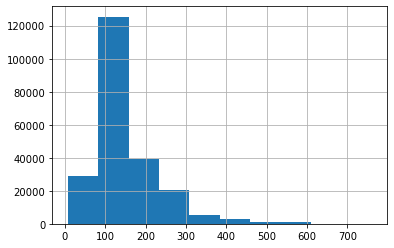

In [35]:
# посмотрим на гистограмму распределения значений
data.enginePower.hist()
data.enginePower.describe()

По гистограмме видим правостороннию ассиметрию распределения, среднее значние мощности двигателя ~187 л.с, реже встречаются автомобили с более мощными двигателями (300 л.с. и более). Выбросов и аномалий не наблюдается. Для того, чтобы сделать распреление данной переменной более нормальным, поробуем логарифмировать ее.

In [36]:
data.enginePower = data.enginePower.apply(lambda x: np.log(x))

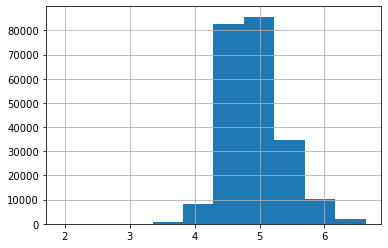

In [37]:
# новая гистограмма распределения логарифмированных данных
data.enginePower.hist()

6. equipment_dict

In [38]:
# столбец содержит ряд интересных признаков
data.equipment_dict[0]

'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

In [39]:
# преобразуем значение переменной в список для возможности дальнейшего преобразования в dummy-переменную
def dict_proccesing(s):
    s = s.replace('true', '"true"')
    dict1 = eval(s)
    li = []
    for key in dict1.keys():
        if (key not in li) and (dict1[key] == 'true'):
            li.append(key)
    if len(li) >= 1:
        return li
    else:
        return ['NaN']


data.equipment_dict = data.equipment_dict.apply(
    lambda x: ['NaN'] if pd.isna(x) else dict_proccesing(x))

7. fuelType

In [40]:
# не замечено аномалий и ошибок в значениях, оставим столбец без обработки
data.fuelType.value_counts()

бензин     196705
дизель      25935
гибрид        966
электро       331
газ            46
Name: fuelType, dtype: int64

8. mileage

In [41]:
data.mileage.value_counts()

200000    3816
150000    3276
250000    2540
180000    2444
100000    2379
          ... 
33985        1
206005       1
154778       1
150680       1
2049         1
Name: mileage, Length: 52902, dtype: int64

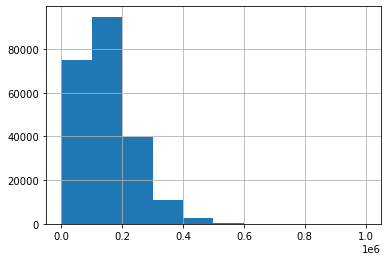

In [42]:
# построим гистограмму распределения
data.mileage.hist()

In [43]:
data.mileage.describe()

count     223983.000000
mean      150291.099481
std        95519.752812
min            1.000000
25%        82214.000000
50%       138000.000000
75%       200000.000000
max      1000000.000000
Name: mileage, dtype: float64

По гистограмме видно, что распределение имеет правостороннюю ассиметрию, есть экстимально высокие значения, например 1000000
Минимальная величина - 1 
Максимальная - 1000000

9. modelDate

In [44]:
data.modelDate.value_counts()

2011    14855
2010    13714
2012    13159
2015    13053
2009    12223
        ...  
1957        1
1961        1
1933        1
1904        1
1927        1
Name: modelDate, Length: 87, dtype: int64

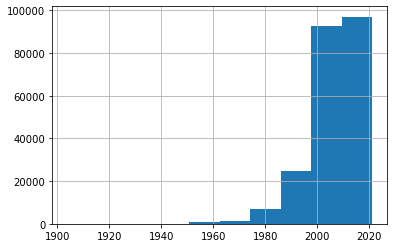

In [45]:
# посмотрим на распределение
data.modelDate.hist()

По гистограмме видим левостороннюю ассиметрию, то есть значительно больше относительно новых автомобилей. Это соответствует и здравому смыслу и тому, что мы наблюдали при анализе распределения по пробегу автомобилей

In [46]:
data.modelDate.describe()

count    223983.000000
mean       2005.984182
std           9.521517
min        1904.000000
25%        2002.000000
50%        2008.000000
75%        2012.000000
max        2021.000000
Name: modelDate, dtype: float64

10. model_info

In [47]:
json.loads(data.model_info[0])

{'code': 'OCTAVIA',
 'name': 'Octavia',
 'ru_name': 'Октавия',
 'morphology': {'gender': 'FEMININE'},
 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}

Полезной информации данный стобец не содержит, к тому же есть много пропусков по данным, удалим его 

In [48]:
# извлечем признак 'женский' автомобиль "morphology":{"gender":"FEMININE"}
#data.model_info = data.model_info.apply(lambda x: None if pd.isna(x) else json.loads(x)['morphology']['gender'] if 'gender' in x else 'MALE')

In [49]:
data.model_info

0         {"code":"OCTAVIA","name":"Octavia","ru_name":"...
1         {"code":"OCTAVIA","name":"Octavia","ru_name":"...
2         {"code":"SUPERB","name":"Superb","ru_name":"Су...
3         {"code":"OCTAVIA","name":"Octavia","ru_name":"...
4         {"code":"OCTAVIA","name":"Octavia","ru_name":"...
                                ...                        
225801    {"code": "PATRIOT", "name": "Patriot", "ru_nam...
225802    {"code": "PATRIOT", "name": "Patriot", "ru_nam...
225803    {"code": "HUNTER", "name": "Hunter", "ru_name"...
225804    {"code": "PATRIOT", "name": "Patriot", "ru_nam...
225805    {"code": "3151", "name": "3151", "ru_name": "3...
Name: model_info, Length: 223983, dtype: object

11. model_name

In [50]:
# не замечено аномалий в значениях, оставим столбец без обработки
data.model_name.value_counts()

FOCUS       3875
OCTAVIA     3792
GRANTA      3537
RIO         3333
SOLARIS     3288
            ... 
SVX            1
ROADSTER       1
SANTANA        1
COWRY          1
THATS          1
Name: model_name, Length: 1463, dtype: int64

12. numberOfDoors

In [51]:
data.numberOfDoors.value_counts()
# 0 - это не ошибка, есть такая модель, оставляем данные без изменений

5    120668
4     91352
3      7915
2      4033
0        14
1         1
Name: numberOfDoors, dtype: int64

In [52]:
data[data.numberOfDoors == 0]

,bodyType,brand,car_url,color,complectation_dict,seller_type,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_info,model_name,numberOfDoors,priceCurrency,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,sample,price
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,3.465736,[NaN],бензин,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,0,RUB,1904,1093802104,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,0,0
90351,внедорожник,LUAZ,https://auto.ru/cars/used/sale/LUAZ/967/110330...,зелёный,NaN,PRIVATE,1.2,3.610918,[NaN],бензин,30000,1965,"{""code"": ""967"", ""name"": ""967"", ""ru_name"": ""967...",967,0,RUR,1986,1103308446,механическая,RUSSIAN,3 или более,Дубликат,полный,Левый,1,80000
90361,внедорожник,LUAZ,https://auto.ru/cars/used/sale/LUAZ/967/110093...,зелёный,NaN,PRIVATE,1.2,3.610918,[NaN],бензин,20000,1965,"{""code"": ""967"", ""name"": ""967"", ""ru_name"": ""967...",967,0,RUR,1983,1100935502,механическая,RUSSIAN,3 или более,Оригинал,полный,Левый,1,400000
90367,внедорожник,LUAZ,https://auto.ru/cars/used/sale/LUAZ/967/108415...,зелёный,NaN,PRIVATE,1.2,3.610918,[NaN],бензин,7000,1965,"{""code"": ""967"", ""name"": ""967"", ""ru_name"": ""967...",967,0,RUR,1978,1084158631,механическая,RUSSIAN,2 владельца,Дубликат,полный,Левый,1,550000
109076,внедорожник,GAZ,https://auto.ru/cars/used/sale/GAZ/64/10864799...,зелёный,NaN,COMMERCIAL,3.3,3.912023,[NaN],бензин,1000,1941,"{""code"": ""64"", ""name"": ""64"", ""ru_name"": ""64"", ...",64,0,RUR,1941,1086479926,механическая,RUSSIAN,3 или более,Оригинал,полный,Левый,1,5750000
109163,внедорожник,LUAZ,https://auto.ru/cars/used/sale/LUAZ/967/110330...,зелёный,NaN,PRIVATE,1.2,3.610918,[NaN],бензин,25000,1965,"{""code"": ""967"", ""name"": ""967"", ""ru_name"": ""967...",967,0,RUR,1987,1103309077,механическая,RUSSIAN,2 владельца,Оригинал,полный,Левый,1,180000
109168,внедорожник,LUAZ,https://auto.ru/cars/used/sale/LUAZ/967/109765...,зелёный,NaN,PRIVATE,1.2,3.610918,[NaN],бензин,90000,1965,"{""code"": ""967"", ""name"": ""967"", ""ru_name"": ""967...",967,0,RUR,1982,1097657766,механическая,RUSSIAN,3 или более,Оригинал,полный,Левый,1,900000
109171,внедорожник,LUAZ,https://auto.ru/cars/used/sale/LUAZ/967/109408...,белый,NaN,COMMERCIAL,1.2,3.610918,[NaN],бензин,1000,1965,"{""code"": ""967"", ""name"": ""967"", ""ru_name"": ""967...",967,0,RUR,1987,1094086742,механическая,RUSSIAN,3 или более,Оригинал,полный,Левый,1,2875000
143682,внедорожник,LUAZ,https://auto.ru/cars/used/sale/LUAZ/967/110253...,зелёный,NaN,PRIVATE,1.2,3.610918,[NaN],бензин,30000,1965,"{""code"": ""967"", ""name"": ""967"", ""ru_name"": ""967...",967,0,RUR,1987,1102533907,механическая,RUSSIAN,2 владельца,Оригинал,полный,Левый,1,300000
161623,внедорожник,LUAZ,https://auto.ru/cars/used/sale/LUAZ/967/109674...,зелёный,NaN,PRIVATE,1.2,3.610918,[NaN],бензин,100,1965,"{""code"": ""967"", ""name"": ""967"", ""ru_name"": ""967...",967,0,RUR,1984,1096747124,механическая,RUSSIAN,3 или более,Оригинал,полный,Левый,1,450000


13. productionDate

In [53]:
data.productionDate.value_counts()

2012    16978
2008    15517
2013    15467
2011    15289
2014    13048
        ...  
1904        1
1934        1
1944        1
1945        1
1922        1
Name: productionDate, Length: 93, dtype: int64

count    223983.000000
mean       2009.167218
std           7.924370
min        1904.000000
25%        2006.000000
50%        2011.000000
75%        2015.000000
max        2021.000000
Name: productionDate, dtype: float64

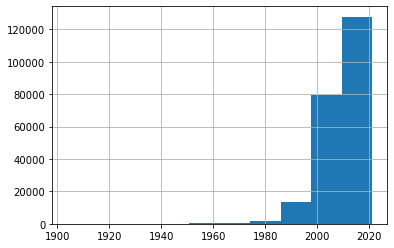

In [54]:
# посмотрим на распределение
data.productionDate.hist()
data.productionDate.describe()

Снова наблюдаем редкие раритетные экземпляры, срдений возраст автомобиля ~ 12 лет (2009 год).

14. sell_id

In [55]:
data.sell_id
# id сделки, используется в submission file

0         1100575026
1         1100549428
2         1100658222
3         1100937408
4         1101037972
             ...    
225801    1099734652
225802    1101853406
225803    1100000190
225804    1094553240
225805    1085569584
Name: sell_id, Length: 223983, dtype: int64

15. vehicleTransmission

In [56]:
# не замечено аномалий и ошибок в значениях, оставим столбец без обработк
data.vehicleTransmission.value_counts()

автоматическая      98800
механическая        94591
роботизированная    15809
вариатор            14783
Name: vehicleTransmission, dtype: int64

16 vendor

In [57]:
# не замечено аномалий и ошибок в значениях, оставим столбец без обработки
data.vendor.value_counts()

EUROPEAN    83696
JAPANESE    58350
RUSSIAN     38510
KOREAN      25024
AMERICAN    14716
CHINESE      3687
Name: vendor, dtype: int64

17. Владельцы

In [58]:
data.Владельцы.value_counts()

3 или более    105822
1 владелец      52782
2 владельца     46641
1 владелец       9459
2 владельца      9270
Name: Владельцы, dtype: int64

In [59]:
# переименуем столбец и переведем в количественную характеристику:
data.Владельцы = data.Владельцы.apply(
    lambda x: None if pd.isna(x) else re.sub('\D', '', x))

In [60]:
data.Владельцы.value_counts()

3    105822
1     62241
2     55911
Name: Владельцы, dtype: int64

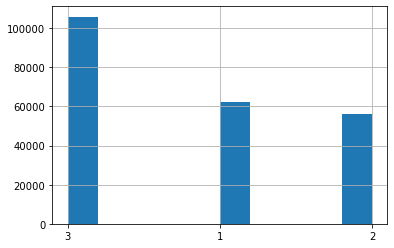

In [61]:
data.Владельцы.hist()

In [62]:
# посмотрим на пустые значения:
data[pd.isna(data.Владельцы)].productionDate

95658     1996
122312    2005
123885    2007
124304    2008
182215    1957
191342    2005
198480    1999
211222    2000
214636    2012
Name: productionDate, dtype: int64

In [63]:
# так как даты проивзводства довольно старые заменим пропуски на наиболее частое значение - 3:
data.Владельцы = data.Владельцы.fillna('3')

In [64]:
data.Владельцы.value_counts()

3    105831
1     62241
2     55911
Name: Владельцы, dtype: int64

19. Владение

In [65]:
# data.Владение.value_counts()
# по данному столбцу можно расчитать число месяцев владения, однако по нему имеется большое количество пропусков

20. ПТС

In [66]:
# Пропуск данных о ПТС заполним частым значением 'Оригинал'
data.ПТС = data['ПТС'].fillna('Оригинал')

In [67]:
data.ПТС.value_counts()

Оригинал    191850
Дубликат     32133
Name: ПТС, dtype: int64

21. Привод

In [68]:
# не замечено аномалий и ошибок в значениях, оставим столбец без обработки
data.Привод.value_counts()

передний    131080
полный       71440
задний       21463
Name: Привод, dtype: int64

22. Руль

In [69]:
# не замечено аномалий и ошибок в значениях, оставим столбец без обработки
data.Руль.value_counts()

Левый     211238
Правый     12745
Name: Руль, dtype: int64

23. priceCurrency

In [70]:
# всегда одна валюта, признак можно удалить
data.priceCurrency.value_counts()

RUR    189297
RUB     34686
Name: priceCurrency, dtype: int64

24. complectation_dict

In [71]:
# содержит много пропусков и избыточной информации, удалим
data.complectation_dict

0                                                       NaN
1                                                       NaN
2         {"id":"20026336","name":"Ambition","available_...
3         {"id":"20803582","name":"Ambition","available_...
4                                                       NaN
                                ...                        
225801                                                  NaN
225802                                                  NaN
225803                                                  NaN
225804    {'id': '21025491', 'name': 'Комфорт', 'availab...
225805                                                  NaN
Name: complectation_dict, Length: 223983, dtype: object

25. price

In [72]:
# посмотрим на распределение целевой переменной
train.price.value_counts()

350000     2151
250000     2124
450000     2049
550000     1763
300000     1723
           ... 
1393890       1
1750300       1
1922400       1
103800        1
1502946       1
Name: price, Length: 8925, dtype: int64

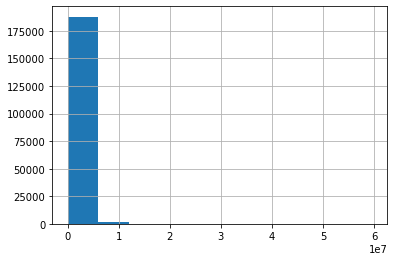

In [73]:
train.price.hist()

In [74]:
# прологарифмируем целевую переменную для получения более нормального распределения
price = train.price.apply(lambda x: np.log(x))

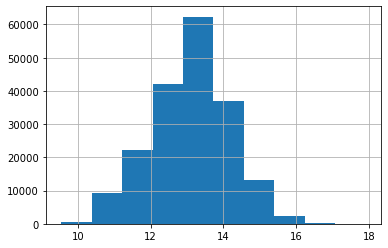

In [75]:
price.hist()

Получение дополнительных признаков:

24. seller_type

In [76]:
train.seller_type.value_counts()

PRIVATE       145203
COMMERCIAL     44094
Name: seller_type, dtype: int64

In [77]:
# из description в test можем получить признак возможности покупки автомобиля в кредит и тип продавца (частник или фирма)
commerce_keywords = ['предоставляем', 'специалист', 'тест-драйв', 'менеджер', 'техническая поддержка', 'trade-in', 'мы предлагаем', 'вы получаете', 'клиент', 'выдача автокредита',
                     'гарантия юридической чистоты', 'в рассрочку', 'мы готовы', 'каждому покупателю', 'предпродажная подготовка', 'наши автомобили', 'нашей компании', 'наших автомобилей']


def desc_type(s):
    f = 0
    for i in commerce_keywords:
        if i in s.lower():
            f += 1
    if f > 0:
        return 'COMMERCIAL'
    else:
        return 'PRIVATE'


test.seller_type = test.seller_type.apply(lambda x: desc_type(x))

In [78]:
test.seller_type.value_counts()

PRIVATE       27719
COMMERCIAL     6967
Name: seller_type, dtype: int64

In [79]:
# удалим все технические переменные из test и train:
train.drop(['sample'], axis=1, inplace=True)
test.drop(['sample', 'price'], axis=1, inplace=True)

In [142]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### Предобработка ##############################################################
    # удаляем технические поля:
    df_output.drop(['sell_id', 'car_url'], axis=1, inplace=True,)

    # bodyType
    # составим словарь по типам автомобильных кузовов:
    bodyTypedict = ['седан', 'компактвэн', 'универсал', 'купе-хардтоп', 'микровэн', 'седан-хардтоп', 'хэтчбек', 'купе', 'лимузин', 'микроавтобус', 'минивэн', 'чардтоп', 'таун-кар',
                    'внедорожник', 'комби', 'лифтбек', 'фастбек', 'кабриолет', 'родстер', 'фаэтон', 'ландо', 'брогам', 'тарга', 'спайдер', 'шутингбрейк', 'пикап', 'фастбек', 'фургон']
    # преобразовываем данные по словарю:
    df_output.bodyType = df_output.bodyType.apply(lambda x: re.split(
        ' ', x.lower())[0] if re.split(' ', x.lower())[0] in bodyTypedict else x)

    # engineDisplacement
    # избавимся от ед. измерения в данных (LTR):
    df_output.engineDisplacement = df_output.engineDisplacement.apply(lambda x: None if pd.isna(x) else re.findall(
        '^\d\.\d', x)[-1] if len(re.findall('\d\.\d', x)) >= 1 else None)
    # заполним пропуске (данные по элетро-автомобилях) нулями:
    df_output.engineDisplacement = df_output.engineDisplacement.fillna('0')

    # enginePower
    # избавимся от единиц измерения
    df_output.enginePower = df_output.enginePower.apply(lambda x: int(
        x.replace(' N12', '')) if 'N12' in x else int(x))

    # Владельцы
    # переименуем столбец и переведем в колличественную характеристику:
    df_output.Владельцы = df_output.Владельцы.apply(
        lambda x: '3' if pd.isna(x) else re.sub('\D', '', x))

    # ПТС
    # Пропуск данных о ПТС заполним частым значением 'Оригинал', переименуем столбец pts
    df_output.ПТС = df_output['ПТС'].fillna('Оригинал')

    # ################### fix ##############################################################
    # Переводим признаки из float в int (иначе catboost выдает ошибку)
    for feature in df_output.select_dtypes(include=['float64']).columns:
        df_output[feature] = df_output[feature].astype('int64')

    # ################### Feature Engineering ####################################################
    # добавили ранее

    # ################### Clean ####################################################
    # убираем признаки которые еще не успели обработать и избыточные
    df_output.drop(['model_info', 'priceCurrency', 'complectation_dict',
                    'equipment_dict'], axis=1, inplace=True,)

    return df_output

In [143]:
train_preproc = preproc_data(train)
X_sub = preproc_data(test)

In [145]:
X_sub = X_sub.reindex(columns=sorted(X_sub.columns))
train_preproc = train_preproc.reindex(columns=sorted(train_preproc.columns))

Обрежем тренировочные данные по разнообразию брендов и моделей с привязкой к значениям в test: 

In [146]:
train_preproc = train_preproc[train_preproc.brand.isin(
    X_sub.brand.value_counts().index.tolist())]
train_preproc = train_preproc[train_preproc.model_name.isin(
    X_sub.model_name.value_counts().index.tolist())]

Зададим X и y: 

In [85]:
X = train_preproc.drop(['price'], axis=1,)
y = train_preproc.price.values

## Train Split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# CatBoost 


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Сat features
CatBoost умеет самостоятельно обрабатывать категориальные признаки, но для корректной обработки нужно их указать:

In [87]:
# чтобы не писать весь список этих признаков, просто вывел их через nunique(). и так сойдет)
X_train.nunique()

bodyType                  16
brand                     12
color                     16
engineDisplacement        54
enginePower              306
fuelType                   5
mileage                15627
modelDate                 55
model_name               502
numberOfDoors              4
productionDate            58
seller_type                2
vehicleTransmission        4
vendor                     2
Владельцы                  3
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [88]:
# Keep list of all categorical features in dataset to specify this for CatBoost
cat_features_ids = np.where(X_train.apply(
    pd.Series.nunique) < 3000)[0].tolist()
cat_features_ids

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [96]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Fit

#### Начальная модель

In [89]:
model = CatBoostRegressor(iterations=ITERATIONS,
                          learning_rate=LR,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          )
model.fit(X_train, y_train,
          cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7534296	test: 1.7299567	best: 1.7299567 (0)	total: 316ms	remaining: 10m 32s
100:	learn: 0.2240664	test: 0.2119690	best: 0.2119690 (100)	total: 16.4s	remaining: 5m 9s
200:	learn: 0.1918831	test: 0.1847638	best: 0.1847638 (200)	total: 33.6s	remaining: 5m 1s
300:	learn: 0.1779313	test: 0.1732320	best: 0.1732170 (299)	total: 50.5s	remaining: 4m 45s
400:	learn: 0.1714919	test: 0.1685459	best: 0.1684423 (398)	total: 1m 8s	remaining: 4m 32s
500:	learn: 0.1666642	test: 0.1649850	best: 0.1649850 (500)	total: 1m 26s	remaining: 4m 18s
600:	learn: 0.1624915	test: 0.1618744	best: 0.1618744 (600)	total: 1m 43s	remaining: 4m
700:	learn: 0.1589938	test: 0.1592394	best: 0.1592133 (696)	total: 2m	remaining: 3m 42s
800:	learn: 0.1568355	test: 0.1582871	best: 0.1582822 (798)	total: 2m 17s	remaining: 3m 25s
900:	learn: 0.1541906	test: 0.1565904	best: 0.1565904 (900)	total: 2m 35s	remaining: 3m 9s
1000:	learn: 0.1519305	test: 0.1552226	best: 0.1552092 (997)	total: 2m 53s	remaining: 2m 53s
1100:	

In [93]:
model.save_model('catboost_model_1.model')

In [94]:
predict_test = model.predict(X_test)
predict_submission = model.predict(X_sub)

In [97]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.89%


# Submission

In [100]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v1.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,7.096692e+05
1,1100549428,1.069111e+06
2,1100658222,9.303833e+05
3,1100937408,8.208756e+05
4,1101037972,7.261195e+05
5,1100912634,8.148515e+05
6,1101228730,6.930628e+05
7,1100165896,4.586250e+05
8,1100768262,2.148794e+06
9,1101218501,1.040876e+06


#### Модель с логарифмированием целевой переменной

In [105]:
modellog = CatBoostRegressor(iterations=ITERATIONS,
                          learning_rate=LR,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          )
modellog.fit(X_train, np.log(y_train),
          cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0543130	test: 0.0539762	best: 0.0539762 (0)	total: 157ms	remaining: 5m 13s
100:	learn: 0.0122789	test: 0.0120543	best: 0.0120543 (100)	total: 14.8s	remaining: 4m 38s
200:	learn: 0.0110539	test: 0.0110014	best: 0.0110014 (200)	total: 30.6s	remaining: 4m 34s
300:	learn: 0.0104879	test: 0.0105621	best: 0.0105621 (300)	total: 47.6s	remaining: 4m 28s
400:	learn: 0.0101540	test: 0.0103409	best: 0.0103409 (400)	total: 1m 6s	remaining: 4m 26s
500:	learn: 0.0098917	test: 0.0101662	best: 0.0101662 (500)	total: 1m 24s	remaining: 4m 13s
600:	learn: 0.0096944	test: 0.0100681	best: 0.0100681 (598)	total: 1m 41s	remaining: 3m 57s
700:	learn: 0.0095184	test: 0.0099791	best: 0.0099791 (700)	total: 2m 1s	remaining: 3m 44s
800:	learn: 0.0093901	test: 0.0099182	best: 0.0099182 (800)	total: 2m 20s	remaining: 3m 29s
900:	learn: 0.0092729	test: 0.0098822	best: 0.0098818 (899)	total: 2m 37s	remaining: 3m 11s
1000:	learn: 0.0091616	test: 0.0098407	best: 0.0098407 (1000)	total: 2m 54s	remaining: 2m 

In [106]:
predict_test = np.exp(modellog.predict(X_test))
predict_submission = np.exp(modellog.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.94%


In [107]:
modellog.save_model('catboost_model_log.model')

In [108]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}_log.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,7.041963e+05
1,1100549428,1.060094e+06
2,1100658222,9.380355e+05
3,1100937408,8.430989e+05
4,1101037972,7.832728e+05
5,1100912634,8.226577e+05
6,1101228730,7.333895e+05
7,1100165896,4.821873e+05
8,1100768262,2.030250e+06
9,1101218501,8.812407e+05


#### Подбор параметров и кросс-валидация

#### CV
Перед тем как бежать перебирать признаки и модели, поговорим о кросс-валидации ([CV](https://ru.wikipedia.org/wiki/Перекрёстная_проверка))

Когда мы делаем отбор признаков или перебираем настройки модели, мы постоянно смотрим в тестовые данные (X_test), что может привести к подгону под тестовые данные. В итоге мы получим Переобучение (**overfitting**).     
Чтобы избежать этого, можно сразу использовать кросс-валидацию по фолдам (подробнее в модуле *Классический Machine Learning >Модуль 7. Валидация данных >7.2. Разбиение выборки*). 

In [109]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations=ITERATIONS,
                              learning_rate=LR,
                              eval_metric='MAPE',
                              random_seed=RANDOM_SEED,)
    model.fit(X_train, np.log(y_train),
              cat_features=cat_features_ids,
              eval_set=(X_test, np.log(y_test)),
              verbose=False,
              use_best_model=True,
              plot=False)

    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [110]:
# куда пишем предикты по каждой модели
submissions = pd.DataFrame(0, columns=["sub_1"], index=sample_submission.index)
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True,
                    random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = np.exp(model.predict(X_test))
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] =  np.exp(model.predict(X_sub))
    model.save_model(f'catboost_fold_{idx+1}.model')

print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.128
2 Fold Test MAPE: 0.127
3 Fold Test MAPE: 0.128
4 Fold Test MAPE: 0.128
5 Fold Test MAPE: 0.128

Mean Score: 0.128
Std Score: 0.0004
Max Score: 0.128
Min Score: 0.127


### Submissions blend

In [111]:
submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5
0,7.195605e+05,7.048772e+05,7.322083e+05,7.104087e+05,7.093465e+05
1,1.039984e+06,1.074219e+06,1.079676e+06,1.047301e+06,1.066772e+06
2,9.694768e+05,9.206430e+05,9.498788e+05,9.288577e+05,9.515874e+05
3,8.512569e+05,8.558686e+05,8.515617e+05,8.557541e+05,8.424985e+05
4,7.805432e+05,7.992115e+05,7.887031e+05,7.859527e+05,7.756540e+05
5,8.109376e+05,8.012319e+05,8.217176e+05,7.882653e+05,8.102650e+05
6,7.329354e+05,7.016288e+05,7.238002e+05,7.185174e+05,7.282755e+05
7,4.664270e+05,4.703476e+05,4.718349e+05,4.844318e+05,4.729775e+05
8,2.088007e+06,2.050726e+06,2.050933e+06,2.132049e+06,2.070456e+06
9,8.558185e+05,8.438678e+05,8.764838e+05,8.756134e+05,8.696443e+05


In [112]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_v{VERSION})cv.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,7.152802e+05
1,1100549428,1.061590e+06
2,1100658222,9.440887e+05
3,1100937408,8.513880e+05
4,1101037972,7.860129e+05
5,1100912634,8.064835e+05
6,1101228730,7.210314e+05
7,1100165896,4.732038e+05
8,1100768262,2.078434e+06
9,1101218501,8.642856e+05


Для того, чтобы перейти к построению других моделей, выполним преобразование категориальных переменных

#### Label Encoding

In [148]:
train_preproc_enc = train_preproc.copy()
X_sub_enc = X_sub.copy()

In [150]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train_preproc_enc['sample'] = 1 # помечаем где у нас трейн
X_sub_enc['sample'] = 0 # помечаем где у нас тест

data_enc = X_sub_enc.append(train_preproc_enc, sort=False).reset_index(drop=True) # объединяем

In [151]:
data_enc.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,seller_type,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,sample,price
0,лифтбек,SKODA,синий,1.2,105,бензин,74000,2013,OCTAVIA,5,2014,COMMERCIAL,роботизированная,EUROPEAN,3,Оригинал,передний,Левый,0,NaN
1,лифтбек,SKODA,чёрный,1.6,110,бензин,60563,2017,OCTAVIA,5,2017,COMMERCIAL,механическая,EUROPEAN,1,Оригинал,передний,Левый,0,NaN


In [156]:
from sklearn import preprocessing
bin_cols = ['bodyType','brand','color', 'engineDisplacement', 'fuelType', 'model_name','vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'seller_type', 'vendor']
label_encoder = preprocessing.LabelEncoder()
for column in bin_cols:
    data_enc[column] = label_encoder.fit_transform(data_enc[column])
data_enc.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,seller_type,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,sample,price
0,6,8,13,5,105,0,74000,2013,316,5,2014,0,3,0,3,1,1,0,0,NaN
1,6,8,15,9,110,0,60563,2017,316,5,2017,0,2,0,1,1,1,0,0,NaN
2,6,8,12,11,152,0,88000,2013,453,5,2014,0,3,0,1,1,1,0,0,NaN
3,6,8,6,9,110,0,95000,2013,316,5,2014,0,0,0,1,1,1,0,0,NaN
4,6,8,1,11,152,0,58536,2008,316,5,2012,0,0,0,1,1,1,0,0,NaN


In [ ]:
#снова разделим данные: 

In [173]:
train_preproc_enc = data_enc.query('sample == 1').drop(['sample'], axis=1)
X_sub_enc = data_enc.query('sample == 0').drop(['sample'], axis=1)
X_sub_enc = X_sub_enc.drop(['price'], axis=1)

In [174]:
X = train_preproc_enc.drop(['price'], axis=1,)
y = train_preproc_enc.price.values

In [175]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [177]:
X_sub_enc

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,seller_type,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль
0,6,8,13,5,105,0,74000,2013,316,5,2014,0,3,0,3,1,1,0
1,6,8,15,9,110,0,60563,2017,316,5,2017,0,2,0,1,1,1,0
2,6,8,12,11,152,0,88000,2013,453,5,2014,0,3,0,1,1,1,0
3,6,8,6,9,110,0,95000,2013,316,5,2014,0,0,0,1,1,1,0
4,6,8,1,11,152,0,58536,2008,316,5,2012,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,11,1,6,9,136,0,115000,2011,20,4,2014,1,0,0,3,1,0,0
34682,11,1,15,13,190,3,98000,2016,25,4,2018,1,0,0,1,1,2,0
34683,11,1,12,18,170,0,360000,1995,25,4,1997,1,0,0,3,0,0,0
34684,0,1,6,13,184,3,90500,2012,518,5,2013,1,0,0,2,1,2,0


#### CatBoost с Label Encoding

In [203]:
modellog = CatBoostRegressor(iterations=ITERATIONS,
                          learning_rate=LR,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          )
modellog.fit(X_train, np.log(y_train),
          #cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )

0:	learn: 0.0541075	test: 0.0537601	best: 0.0537601 (0)	total: 1.08s	remaining: 36m 7s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

100:	learn: 0.0117763	test: 0.0119714	best: 0.0119714 (100)	total: 4.21s	remaining: 1m 19s
200:	learn: 0.0106377	test: 0.0109060	best: 0.0109060 (200)	total: 6.08s	remaining: 54.5s
300:	learn: 0.0100263	test: 0.0104083	best: 0.0104083 (300)	total: 8.32s	remaining: 47s
400:	learn: 0.0096595	test: 0.0101556	best: 0.0101556 (400)	total: 9.96s	remaining: 39.7s
500:	learn: 0.0093914	test: 0.0099856	best: 0.0099856 (500)	total: 11.6s	remaining: 34.8s
600:	learn: 0.0091728	test: 0.0098737	best: 0.0098737 (600)	total: 13.8s	remaining: 32.2s
700:	learn: 0.0089962	test: 0.0097916	best: 0.0097914 (698)	total: 15.8s	remaining: 29.2s



800:	learn: 0.0088403	test: 0.0097200	best: 0.0097200 (799)	total: 17.6s	remaining: 26.4s
900:	learn: 0.0086994	test: 0.0096596	best: 0.0096596 (900)	total: 19.4s	remaining: 23.7s
1000:	learn: 0.0085780	test: 0.0096138	best: 0.0096135 (999)	total: 21.1s	remaining: 21s
1100:	learn: 0.0084708	test: 0.0095792	best: 0.0095788 (1097)	total: 22.8s	remaining: 18.6s
1200:	l

In [204]:
predict_test = np.exp(modellog.predict(X_test))
predict_submission = np.exp(modellog.predict(X_sub_enc))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.65%


In [205]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}_log_enc.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.176314e+06
1,1100549428,5.176314e+06
2,1100658222,5.176314e+06
3,1100937408,5.119847e+06
4,1101037972,5.119847e+06
5,1100912634,5.176314e+06
6,1101228730,5.382746e+06
7,1100165896,5.176314e+06
8,1100768262,5.690080e+06
9,1101218501,5.382746e+06


#### GradientBoosting

In [178]:
from sklearn.ensemble import GradientBoostingRegressor
modelgb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000).fit(X_train, np.log(y_train))

In [179]:
predict_test = np.exp(modelgb.predict(X_test))
predict_submission = np.exp(modelgb.predict(X_sub_enc))

In [180]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.11%


#### RandomForest

In [181]:
from sklearn.ensemble import RandomForestRegressor
modelrf = RandomForestRegressor(n_estimators=1000, max_depth = 15, max_features = 'log2', random_state = 42, oob_score=True,).fit(X_train, np.log(y_train))

In [182]:
predict_test = np.exp(modelrf.predict(X_test)) 
predict_submission = np.exp(modelrf.predict(X_sub_enc))

In [183]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.12%


#### Бэггинг

In [185]:
from sklearn.ensemble import BaggingRegressor
bg = BaggingRegressor(modelrf, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED).fit(X_train, np.log(y_train))
predict_submission = np.exp(bg.predict(X_test))

In [186]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.12%


По результатам оценки эффективности модели, лучшее решение предоставояет CatBoost с кросс-валидацией

## Stacking 
Давайте сначала разберемся, что-же такое этот Stacking. 
#### Начнем с Ансамбля моделей:     
Допустим, вы обучили Различные модели. Теперь мы можем просто объединить их предсказания и получить средневзвешенное предсказание по всем моделям. При этом, чем разнообразней модели - тем лучше результат мы получим. Смотри пример на картинке 

#### А теперь Stacking:
У нас есть предсказания от разных моделей, почему бы не использовать их как новые признаки/фитчи и не **построить поверх этих предсказаний новую модель**? Это основная идея Stacking-a. 

Далее его еще можно бесконечно усложнять. Например, добавляя модели обученные на разных выборках и/или с разным составом признаков (bagging), или увеличивая уровни стекинга. В итоге мы можем получить что-то монструозное вроде этого:


### Kaggle DarkSide
Большинство победных решений на kaggle сейчас идет со стекингом. И это большой минус kaggle, так как завести такого монстра, в продакшен, на реальный онлайн сервис, практически нереально (я уже молчу про интерпретируемость подобного решения). При этом сам стекинг обычно не играет ключевую роль, но он позволяет докинуть доли процента, которые в соревновании могут оказаться критичными.


* > Перед тем как отправляться "во все тяжкие" со Стекингом, рекомендую побольше поработать с Feature Engineering-ом.
* > При Stacking-e Очень важно изначально продумать и выстроить четкие правила CV, чтоб не допустить утечки данных при обучении.   
На крайний случай, можно воспользоваться готовыми пакетами с уже корректно реализованным Stacking-ом: [vecstack](https://github.com/vecxoz/vecstack), [mlxtend](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/),  [H2O](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

In [206]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [207]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [208]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

In [209]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [210]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
stacked_features_train, stacked_features_test = generate_meta_features([
    LogisticRegression(random_state = 42, C=0.001, penalty='l1', solver='saga', multi_class='ovr', max_iter=2000),
    LogisticRegression(random_state = 42, C=0.001, penalty='l2', solver='saga', multi_class='ovr', max_iter=2000),  
    RandomForestRegressor(n_estimators=2000, max_depth = 15, max_features = 'log2', random_state = 42, oob_score=True,),
    GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=2000)
], X_train, X_test, y_train, cv)

ValueError: shape mismatch: value array of shape (5092,4422) could not be broadcast to indexing result of shape (5092,4673)

In [ ]:
total_features_train = np.hstack([X_train, stacked_features_train])
total_features_test = np.hstack([X_test, stacked_features_test])

In [ ]:
np.random.seed(42)
clf = LogisticRegression( penalty='none', multi_class='auto', solver='lbfgs', random_state=42)
clf.fit(stacked_features_train, y_train)

In [ ]:
score =compute_metric(clf, total_features_train, y_train, total_features_test)

In [ ]:
score

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Подгрузить еще больше данных
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking